# Wprowadzenie i przygotowanie danych

Tu znajdzie się opis danych, pytania badawcze i wczytanie + czyszczenie danych.

In [ ]:
# opisać ten zbiór danych: co zawiera, skąd pochodzi i w jakim celu został stworzony
# https://www.kaggle.com/datasets/unsdsn/world-happiness

# Główna zmienna do analizowania 
#     Life Ladder

# zmienne mogące być zależne
#     GPD
#     Social
#     Life exp
#     freedom
#     hojność
#     korupcja


# Do zbadania:
#     1. Które czynniki (GDP, wsparcie społeczne, długość życia itp.) mają najsilniejszy związek z poziomem szczęścia?
#     2. Czy istnieją istotne różnice w poziomie szczęścia między regionami świata (np. Europa Zachodnia vs. Afryka Subsaharyjska)?
#     3. Czy najbogatsze kraje są rzeczywiście najszczęśliwsze? A może inne czynniki (np. wolność, brak korupcji) odgrywają równie ważną rolę?
#     4. Które kraje odstają od trendów (np. kraj o wysokim PKB a niskim poziomie szczęścia, lub odwrotnie) i dlaczego?

# Dodać kontynenty? regiony czy coś takiego?


```powershell nbmerge notebooks/01_wprowadzenie_i_czyszczenie.ipynb notebooks/02_wizualizacja.ipynb notebooks/03_analiza_statystyczna_i_wnioski.ipynb --output final_project.ipynb .
```


In [1]:
# Importy i wczytanie danych
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [2]:
# wykresy w notebooku oraz ich jakość
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

In [16]:
# wczytanie dataseta i sprawdzenie czy jest wczytany poprawnie
df = pd.read_csv('../data/world-happiness-report.csv')
df.rename(columns={'Country name': 'country'}, inplace=True)
df.rename(columns={'Life Ladder': 'life_ladder'}, inplace=True)
df.rename(columns={'Log GDP per capita' : 'gdp_per_capita'}, inplace=True)
df.rename(columns={'Social support': 'social_support'}, inplace=True)
df.rename(columns={'Healthy life expectancy at birth': 'healthy_expectancy'}, inplace=True)
df.rename(columns={'Freedom to make life choices': 'freedom'}, inplace=True)
df.rename(columns={'Generosity': 'generosity'}, inplace=True)
df.rename(columns={'Perceptions of corruption': 'corruption'}, inplace=True)
df.rename(columns={'Positive affect': 'positive_affect'}, inplace=True)
df.rename(columns={'Negative affect': 'negative_affect'}, inplace=True)
df #.head()

,country,year,life_ladder,gdp_per_capita,social_support,healthy_expectancy,freedom,generosity,corruption,positive_affect,negative_affect
0,Afghanistan,2008,3.724,7.370,0.451,50.80,0.718,0.168,0.882,0.518,0.258
1,Afghanistan,2009,4.402,7.540,0.552,51.20,0.679,0.190,0.850,0.584,0.237
2,Afghanistan,2010,4.758,7.647,0.539,51.60,0.600,0.121,0.707,0.618,0.275
3,Afghanistan,2011,3.832,7.620,0.521,51.92,0.496,0.162,0.731,0.611,0.267
4,Afghanistan,2012,3.783,7.705,0.521,52.24,0.531,0.236,0.776,0.710,0.268
...,...,...,...,...,...,...,...,...,...,...,...
1944,Zimbabwe,2016,3.735,7.984,0.768,54.40,0.733,-0.095,0.724,0.738,0.209
1945,Zimbabwe,2017,3.638,8.016,0.754,55.00,0.753,-0.098,0.751,0.806,0.224
1946,Zimbabwe,2018,3.616,8.049,0.775,55.60,0.763,-0.068,0.844,0.710,0.212
1947,Zimbabwe,2019,2.694,7.950,0.759,56.20,0.632,-0.064,0.831,0.716,0.235


In [4]:
# Sprawdzam ilość brakujących wartości w kolumnach
df_summary = pd.DataFrame({
    "Non-Null Count": df.notnull().sum(),
    "Null Count": df.isnull().sum(),
    "Dtype": df.dtypes
}).sort_values("Null Count", ascending=False)
df_summary

,Non-Null Count,Null Count,Dtype
Perceptions of corruption,1839,110,float64
Generosity,1860,89,float64
Healthy life expectancy at birth,1894,55,float64
Log GDP per capita,1913,36,float64
Freedom to make life choices,1917,32,float64
Positive affect,1927,22,float64
Negative affect,1933,16,float64
Social support,1936,13,float64
Country name,1949,0,object
year,1949,0,int64


In [5]:
df.isnull().sum()

Country name                          0
year                                  0
Life Ladder                           0
Log GDP per capita                   36
Social support                       13
Healthy life expectancy at birth     55
Freedom to make life choices         32
Generosity                           89
Perceptions of corruption           110
Positive affect                      22
Negative affect                      16
dtype: int64

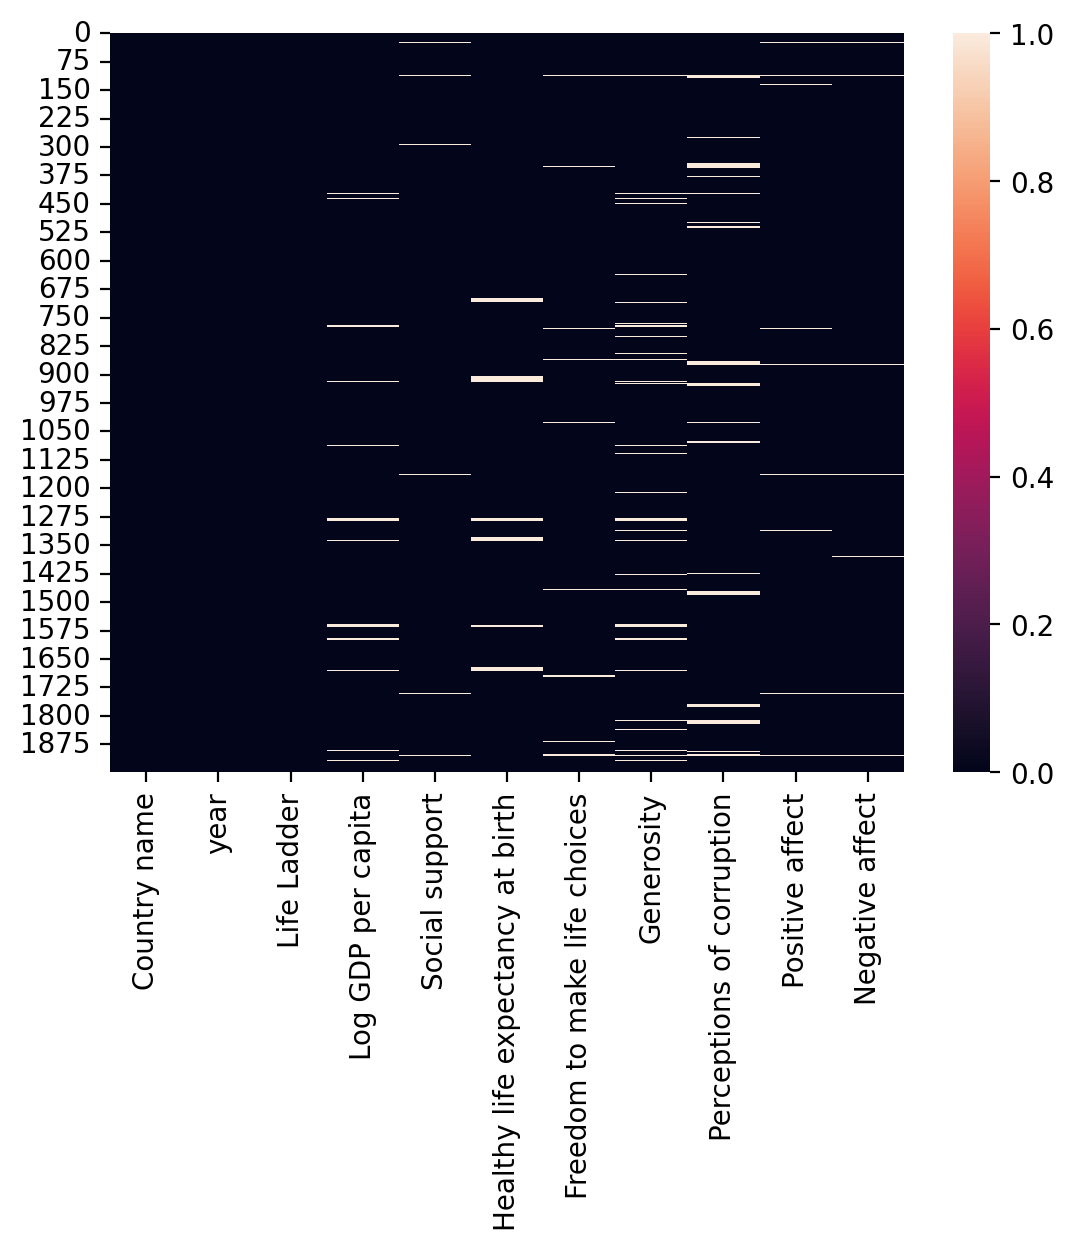

In [6]:
sns.heatmap(df.isna());

<Axes: >

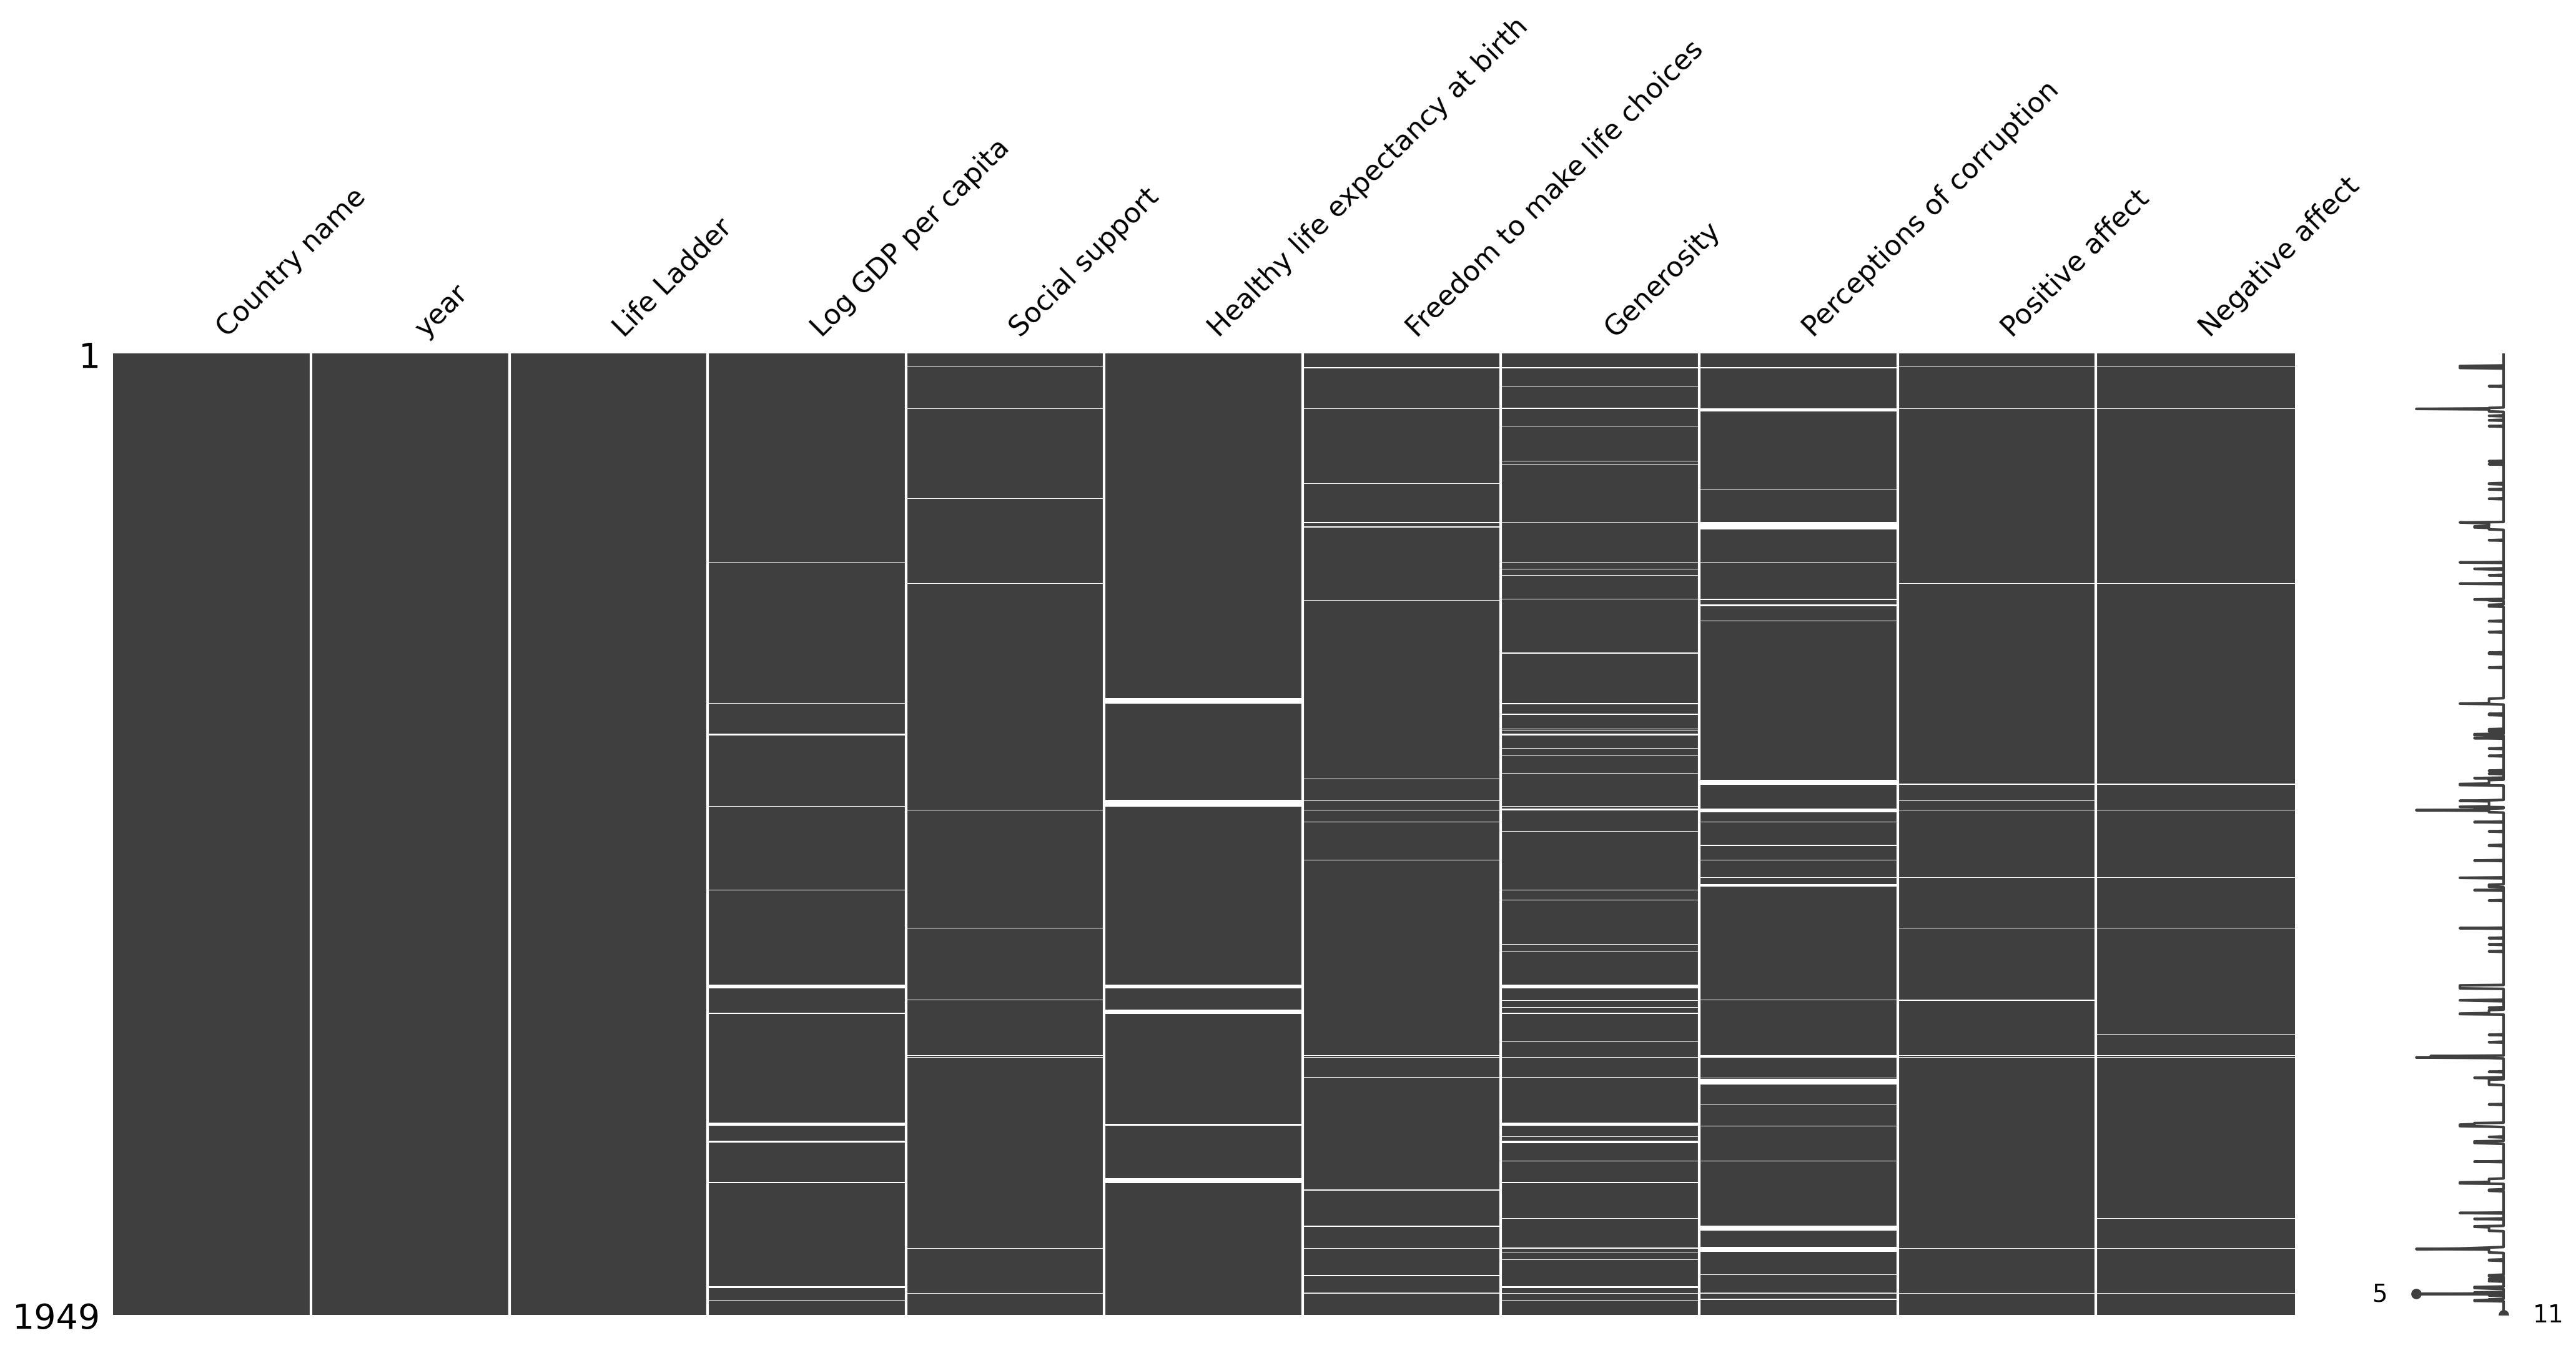

In [8]:
import missingno as msno
msno.matrix(df)

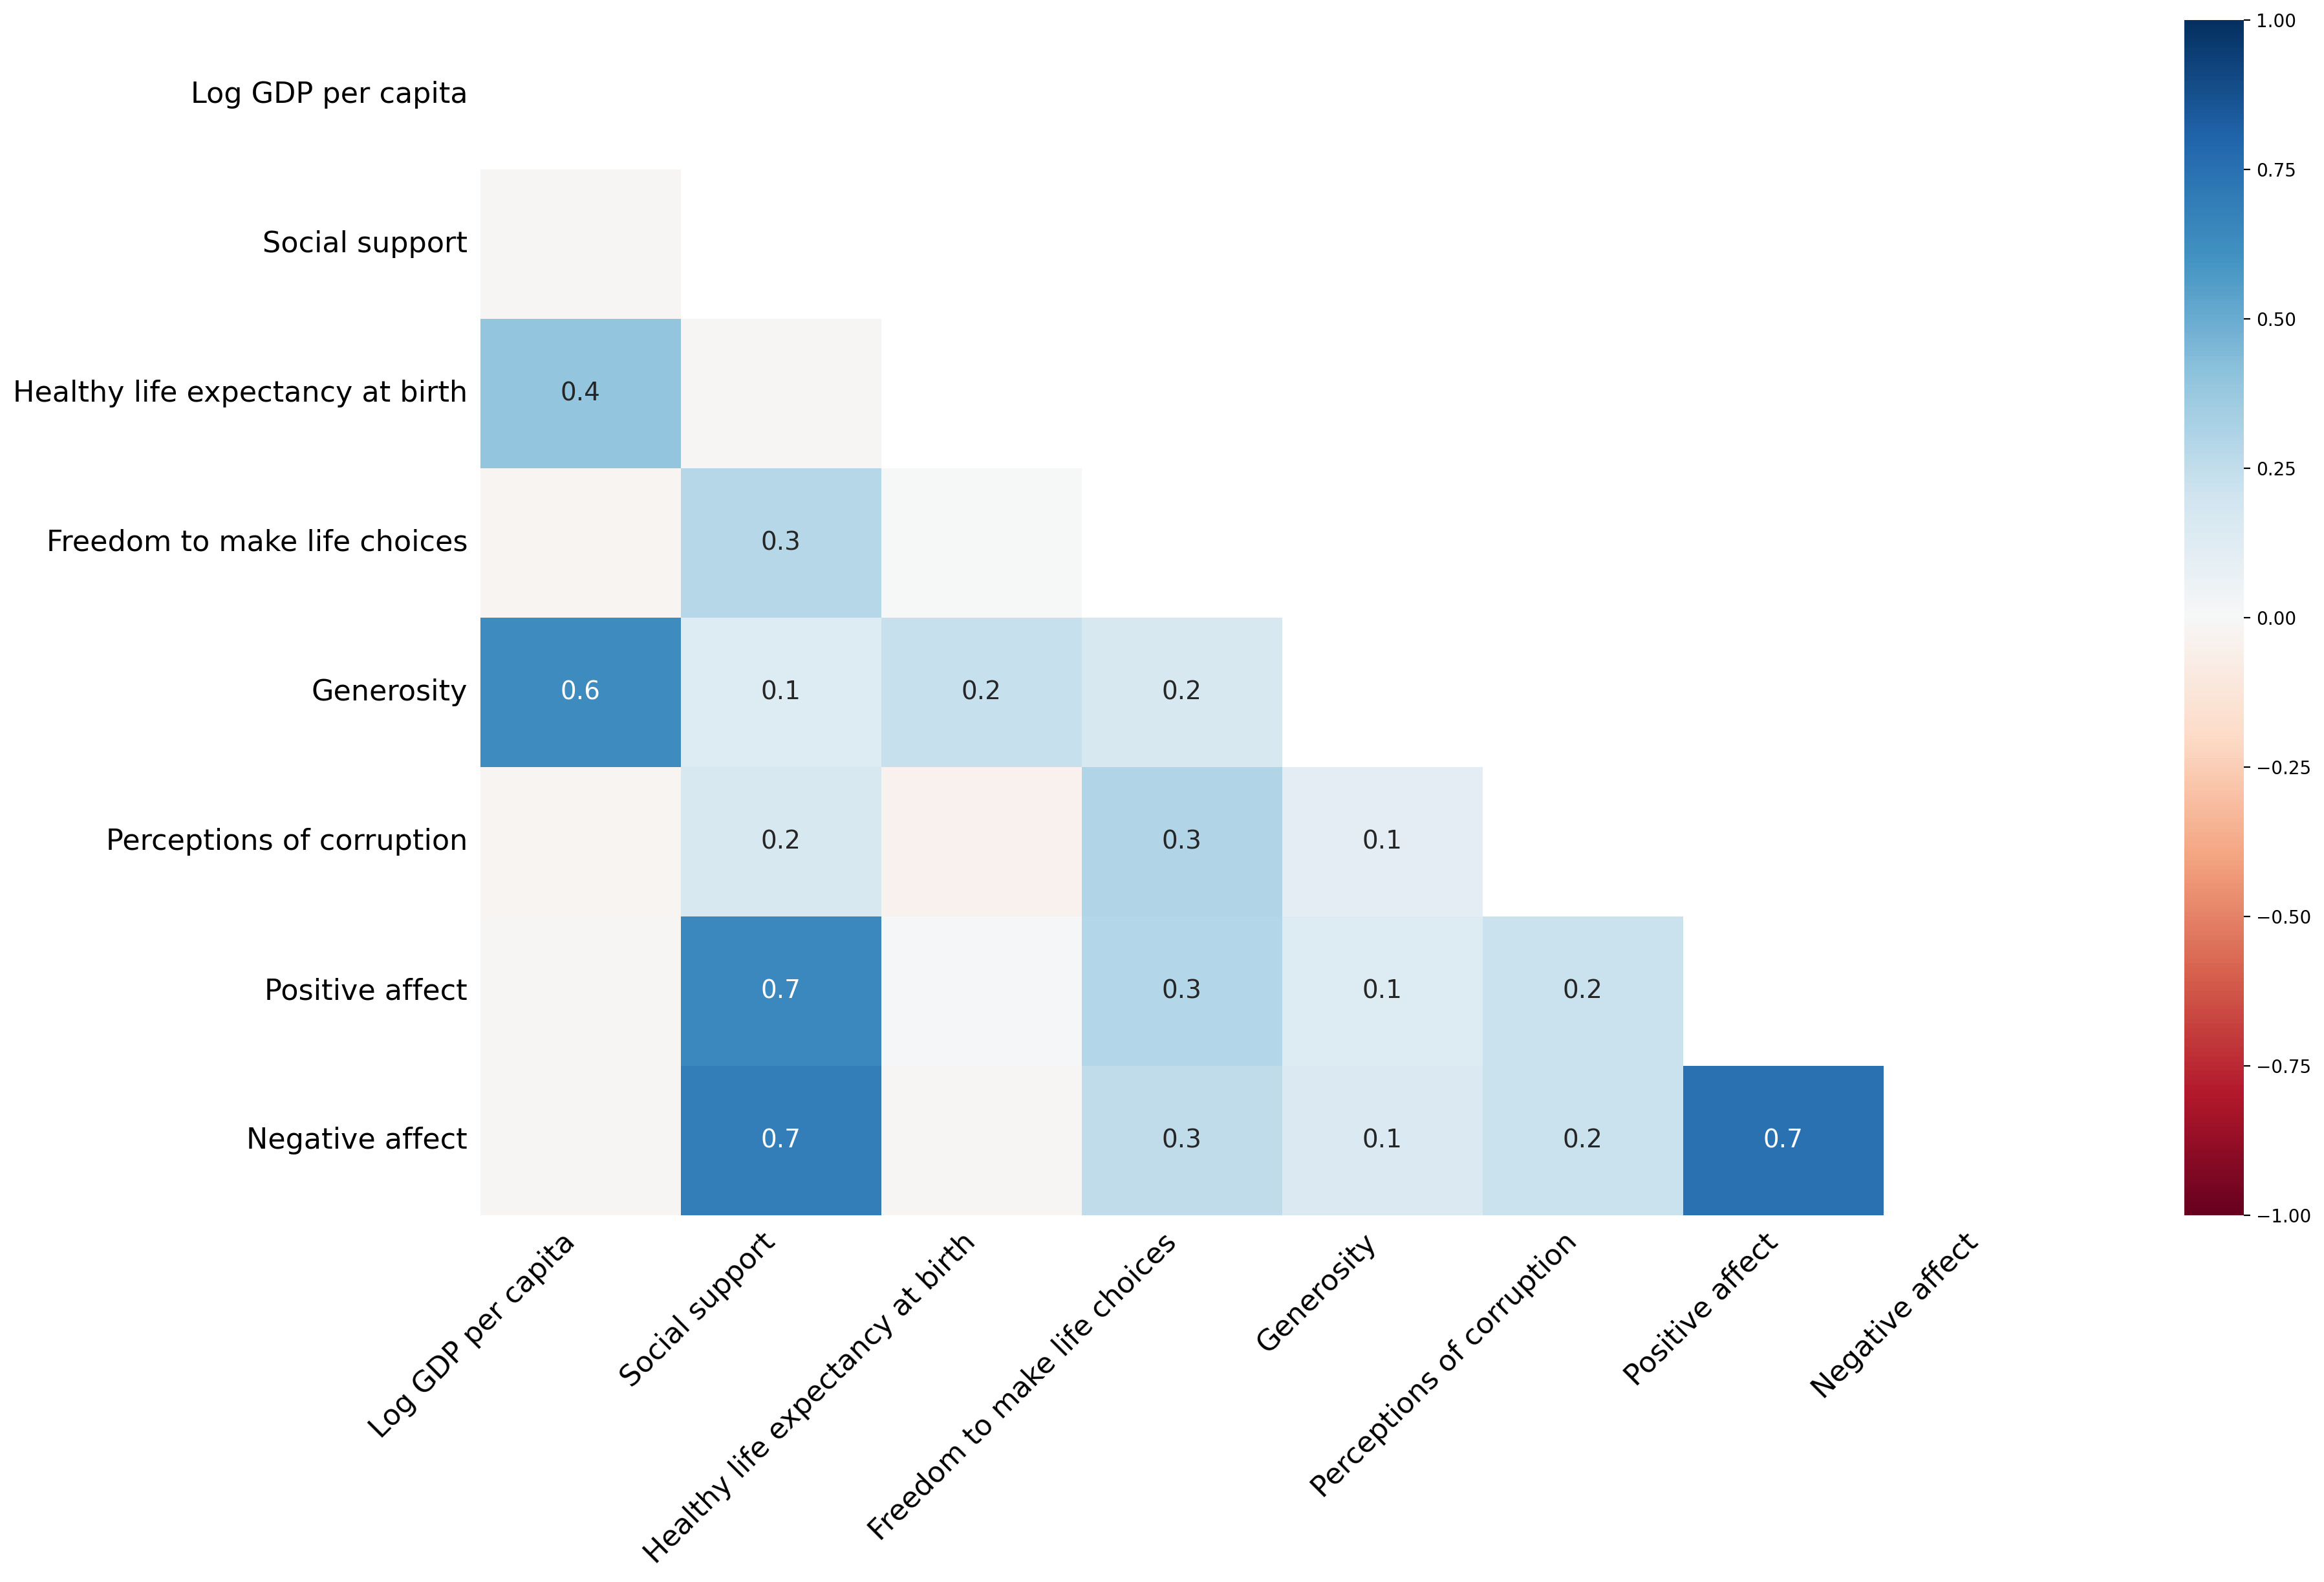

In [9]:
msno.heatmap(df);

In [ ]:
df_cleaned = df
df_cleaned.to_csv('../data/happiness_cleaned.csv', index=False)